In [1]:
import numpy as np
from collections import Counter
from sklearn import datasets
from sklearn.model_selection import train_test_split


In [2]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.mean = None
        self.components = None

    def fit(self, x):
        # compute mean of x
        self.mean = np.mean(x, axis=0)
        x = x - self.mean

        cov = np.cov(x.T)
        eigenvalues, eigenvectors = np.linalg.eig(cov)

        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]
        self.components = eigenvectors[: self.n_components]

    def project(self, x):
        # projects data
        x = x - self.mean
        return np.dot(x, self.components.T)


In [3]:
class Node:
    def __init__(
        self, feature=None, threshold=None, left=None, right=None, *, value=None
    ):
        self.feature = feature  # which feature is used to split this node
        self.threshold = threshold  # which threshold is used
        self.left = left
        self.right = right
        self.value = value  # the most common cats

    def isLeafNode(self):
        return self.value is not None

In [4]:
class DescionTree:
    def __init__(self, min_samples=2, max_depth=100, n_features=None):
        self.min_samples = min_samples
        self.max_depth = max_depth
        self.n_features = (
            n_features  # useful when subset of features used to split the node
        )
        self.root = None  # used for infernece

    def train(self, x, y):
        self.n_features = (
            min(self.n_features, x.shape[1]) if self.n_features else x.shape[1]
        )
        self.root = self.growTree(x, y, 0)

    def growTree(self, x, y, depth):
        # check stopping criteria
        n_samples, n_features = x.shape
        n_categories = len(np.unique(y))
        if depth > self.max_depth or n_samples < self.min_samples or n_categories == 1:
            return Node(value=self.mostCommonCategory(y))  # for leaf node

        # find the best split
        # randomly using subset of n_features size srlf.n_features
        features = np.random.choice(n_features, self.n_features, replace=False)
        best_feature, best_threshold = self.bestSplit(x, y, features)

        # create child nodes using the found best split
        left_idxs, right_idxs = self.split(x[:, best_feature], best_threshold)
        left_child = self.growTree(x[left_idxs, :], y[left_idxs], depth + 1)
        right_child = self.growTree(x[right_idxs, :], y[right_idxs], depth + 1)

        return Node(
            best_feature, best_threshold, left_child, right_child
        )  # for other than leaf node

    def bestSplit(self, x, y, feature_idxs):
        best_gain = -1
        split_feature, split_threshold = None, None

        for feature_idx in feature_idxs:
            x_coloumn = x[:, feature_idx]
            thresholds = np.unique(x_coloumn)

            for threshold in thresholds:
                gain = self.informationGain(y, x_coloumn, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_feature = feature_idx
                    split_threshold = threshold
        return split_feature, split_threshold

    def informationGain(self, y, x_coloumn, threshold):
        # parent entropy
        parent_entropy = self.entropy(y)

        # create children
        left_idxs, right_idxs = self.split(x_coloumn, threshold)

        # calcuclate the weighted avg entropy of children
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        n = len(y)
        n_l = len(left_idxs)
        n_r = len(right_idxs)
        avg_child_entropy = n_l / n * self.entropy(
            y[left_idxs]
        ) + n_r / n * self.entropy(y[right_idxs])
        # calculate information gain
        info_gain = parent_entropy - avg_child_entropy

        return info_gain

    def split(self, x_coloumn, threshold):
        left_idxs = np.argwhere(x_coloumn <= threshold).flatten()
        right_idxs = np.argwhere(x_coloumn > threshold).flatten()
        return left_idxs, right_idxs

    def entropy(self, y):
        hist = np.bincount(y)
        probs = hist / len(y)
        _entropy = -np.sum([prob * np.log2(prob) for prob in probs if prob > 0])
        return _entropy

    def mostCommonCategory(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def test(self, test_x):
        return np.array([self.traverse(self.root, x) for x in test_x])

    def traverse(self, node, x):
        if node.isLeafNode():
            return node.value
        if x[node.feature] < node.threshold:
            return self.traverse(node.left, x)
        return self.traverse(node.right, x)


In [5]:

data = datasets.load_breast_cancer()
X, Y = data.data, data.target
# pca = PCA(100000)
# pca.fit(X)
# X = pca.project(X)

x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=1234
)


clf = DescionTree(max_depth=10)
clf.train(x_train, y_train)
predictions = clf.test(x_test)


def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)


acc = accuracy(y_test, predictions)
print(acc)


0.9298245614035088


In [6]:
class RandomForest:
    def __init__(self, min_samples=2, max_depth=10, n_trees=2, n_features=None):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.n_features = n_features
        self.n_trees = n_trees
        self.forest = []

    def train(self, x, y):
        for _ in range(self.n_trees):
            tree = DescionTree(self.min_samples, self.max_depth, self.n_features)
            x_sample, y_sample = self.bootstrap(x,y)
            tree.train(x_sample, y_sample)
            self.forest.append(tree)

    def bootstrap(self,x, y):
        n_samples = x.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return x[idxs], y[idxs]
    
    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def test(self, x_test):
        predictions = np.array([tree.test(x_test) for tree in self.forest])
        tree_preds = np.swapaxes(predictions, 0, 1)
        predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
        return predictions


In [7]:
data = datasets.load_breast_cancer()
X = data.data
y = data.target
pca = PCA(2000)
pca.fit(X)
X = pca.project(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234
)


def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy


clf = RandomForest(n_trees=20)
clf.train(X_train, y_train)
predictions = clf.test(X_test)

acc = accuracy(y_test, predictions)
print(acc)


0.9649122807017544


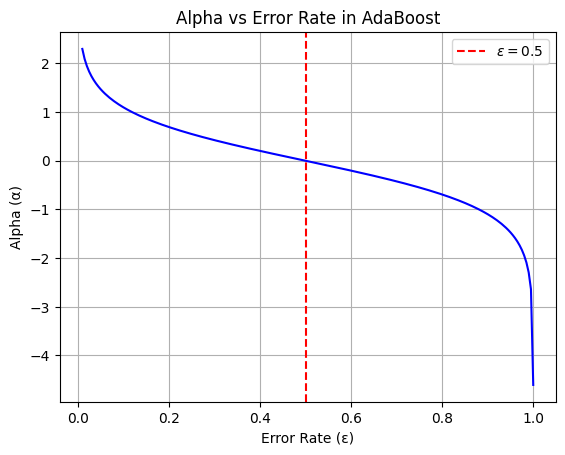

In [8]:

import matplotlib.pyplot as plt

# Define epsilon values using np.linspace (now extending to 1)
epsilon = np.linspace(0.01, 0.9999, 200)  # Generate 200 points from 0.01 to 1

# Compute alpha values using the formula
alpha = 0.5 * np.log((1 - epsilon) / epsilon)

# Plot alpha vs epsilon
plt.plot(epsilon, alpha, color="b")

# Mark a vertical line at epsilon = 0.5
plt.axvline(x=0.5, color="r", linestyle="--", label=r"$\epsilon = 0.5$")

# Label the axes and the plot title
plt.xlabel("Error Rate (ε)")
plt.ylabel("Alpha (α)")
plt.title("Alpha vs Error Rate in AdaBoost")

# Show grid and legend
plt.grid(True)
plt.legend()

# Display the plot
plt.show()


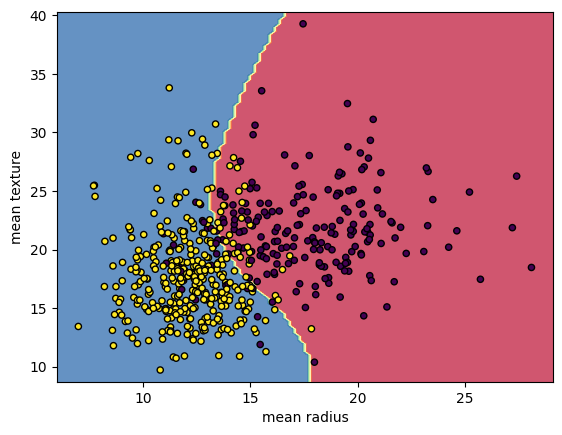

In [24]:
# Load the important packages
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC

# Load the datasets
cancer = load_breast_cancer()
X = cancer.data[:, :2]
y = cancer.target

# Build the model
svm = SVC(kernel="poly", gamma=0.5, C=1)
# Trained the model
svm.fit(X, y)

# Plot Decision Boundary
DecisionBoundaryDisplay.from_estimator(
    svm,
    X,
    response_method="predict",
    cmap=plt.cm.Spectral,
    alpha=0.8,
    xlabel=cancer.feature_names[0],
    ylabel=cancer.feature_names[1],
)

# Scatter plot
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolors="k")
plt.show()


SVM classification accuracy 1.0


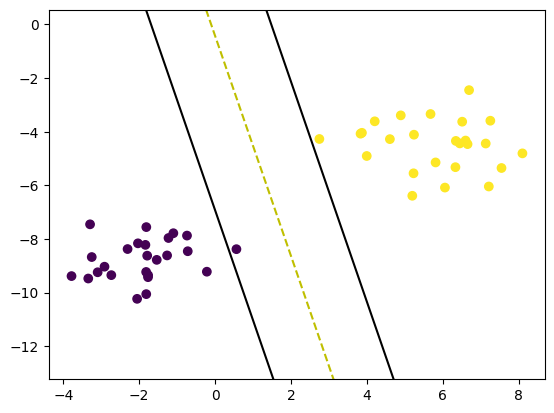

In [ ]:
import numpy as np


class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        y_ = np.where(y <= 0, -1, 1)

        # init weights
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) + self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (
                        2 * self.lambda_param * self.w - np.dot(x_i, y_[idx])
                    )
                    self.b -= self.lr * y_[idx]

    def predict(self, X):
        approx = np.dot(X, self.w) + self.b
        return np.sign(approx)


# Testing
if __name__ == "__main__":
    # Imports
    from sklearn.model_selection import train_test_split
    from sklearn import datasets
    import matplotlib.pyplot as plt

    X, y = datasets.make_blobs(
        n_samples=50, n_features=2, centers=2, cluster_std=1.05, random_state=40
    )
    y = np.where(y == 0, -1, 1)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=123
    )

    clf = SVM(lambda_param=0.5)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)

    def accuracy(y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy

    print("SVM classification accuracy", accuracy(y_test, predictions))

    def visualize_svm():
        def get_hyperplane_value(x, w, b, offset):
            return (-w[0] * x + b + offset) / w[1]

        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        plt.scatter(X[:, 0], X[:, 1], marker="o", c=y)

        x0_1 = np.amin(X[:, 0])
        x0_2 = np.amax(X[:, 0])

        x1_1 = get_hyperplane_value(x0_1, clf.w, clf.b, 0)
        x1_2 = get_hyperplane_value(x0_2, clf.w, clf.b, 0)

        x1_1_m = get_hyperplane_value(x0_1, clf.w, clf.b, -1)
        x1_2_m = get_hyperplane_value(x0_2, clf.w, clf.b, -1)

        x1_1_p = get_hyperplane_value(x0_1, clf.w, clf.b, 1)
        x1_2_p = get_hyperplane_value(x0_2, clf.w, clf.b, 1)

        ax.plot([x0_1, x0_2], [x1_1, x1_2], "y--")
        ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "k")
        ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k")

        x1_min = np.amin(X[:, 1])
        x1_max = np.amax(X[:, 1])
        ax.set_ylim([x1_min - 3, x1_max + 3])

        plt.show()

    visualize_svm()
